# RAPIDS + Numba

### Toy Problem, compute the distance of points to the origin

The toy problem is to compute the distance of the list of points in 2-D space to the origin. First generate 1000 random points and load them to the GPU dataframe

In [3]:
import cudf
import numpy as np
import math
from numba import cuda
import cupy
 
# construct the dataframe to store x and y coordinates of the points
df = cudf.DataFrame()
df['x'] = np.random.rand(1000)
df['y'] = np.random.rand(1000)
df

,x,y
0,0.442126,0.493815
1,0.833536,0.997508
2,0.660121,0.435508
3,0.380233,0.574162
4,0.237941,0.238514
...,...,...
995,0.983216,0.317850
996,0.025951,0.065297
997,0.029504,0.314337
998,0.838586,0.183924


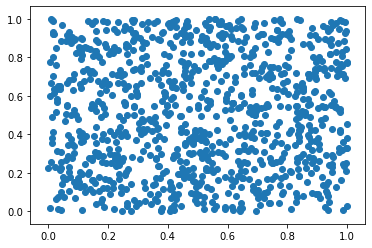

In [8]:
import matplotlib.pyplot as plt

plt.scatter(df.x.to_pandas(), df.y.to_pandas())

Compute the ground truth distance by RAPIDS calls. And define the validation function to make sure the result matchs the ground truth for later use

In [11]:
df['ground_truth'] = cudf.sqrt(df['x']**2 + df['y']**2)

# function to verify the results
def verify(ground_truth, computed):
    max_difference = cudf.sqrt((ground_truth - computed)**2).max()
    assert(max_difference < 1e-8)
    return max_difference

df

,x,y,ground_truth
0,0.442126,0.493815,0.662819
1,0.833536,0.997508,1.299925
2,0.660121,0.435508,0.790839
3,0.380233,0.574162,0.688650
4,0.237941,0.238514,0.336905
...,...,...,...
995,0.983216,0.317850,1.033316
996,0.025951,0.065297,0.070265
997,0.029504,0.314337,0.315718
998,0.838586,0.183924,0.858519


### Customized Kernel by RAPIDS API

This is the easiest way to customize your computations.

Introduce two functions:
* apply_rows
* apply_chunks

`apply_rows` processes each of the rows of the Dataframe independently in parallel. Under the hood, the `apply_rows` method will optimally divide the long columns into chunks, and assign chunks into different GPU blocks and threads to compute. 


To use `apply_rows`, start with a simple Python function to compute the distance. `apply_rows` uses `Numba` to compile it to GPU native code.

In [12]:
def distance_fun(x, y, distance):
    for i, (x_value, y_value) in enumerate(zip(x, y)):
        print('tid:', cuda.threadIdx.x, 'bid:', cuda.blockIdx.x, 'array size:', x.size, 'block threads:', cuda.blockDim.x, 'i', i )
        distance[i] = math.sqrt(x_value**2 + y_value**2)

outdf = df.apply_rows(distance_fun,
                      incols=['x', 'y'],
                      outcols=dict(distance=np.float64),
                      kwargs=dict())

error = verify(outdf['ground_truth'], outdf['distance']) 
error

2.220446049250313e-16

Here is the example output from console for `apply_rows` call
```
...
tid: 27 bid: 11 array size: 1 block threads: 64 i 0
tid: 28 bid: 11 array size: 1 block threads: 64 i 0
tid: 29 bid: 11 array size: 1 block threads: 64 i 0
tid: 30 bid: 11 array size: 1 block threads: 64 i 0
tid: 31 bid: 11 array size: 1 block threads: 64 i 0
tid: 32 bid: 0 array size: 2 block threads: 64 i 1
tid: 33 bid: 0 array size: 2 block threads: 64 i 1
tid: 34 bid: 0 array size: 2 block threads: 64 i 1
tid: 35 bid: 0 array size: 2 block threads: 64 i 1
tid: 36 bid: 0 array size: 2 block threads: 64 i 1
tid: 37 bid: 0 array size: 2 block threads: 64 i 1
...
```
It uses 15 CUDA blocks (0 indexed). Each CUDA block uses 64 threads to do the computation. Each of the threads is handling an array of length 1 or 2. The row element processing order is not defined. 

`apply_chunks` has more control than `apply_rows`.  It can specify how to divide the long array into chunks, map each of the array chunks to different GPU blocks to process (chunks argument) and assign the number of thread in the block (tpb argument).  


In [13]:
def distance_fun(x, y, distance):
    print('tid:', cuda.threadIdx.x, 'bid:', cuda.blockIdx.x, 'array size:', x.size, 'block threads:', cuda.blockDim.x, 'grid dim', cuda.gridDim.x)
    for i in range(cuda.threadIdx.x, x.size, cuda.blockDim.x):
        distance[i] = math.sqrt(x[i]**2 + y[i]**2)

outdf2 = df.apply_chunks(distance_fun,
                      incols=['x', 'y'],
                      outcols=dict(distance=np.float64),
                      kwargs=dict(),
                      chunks=32,
                      tpb=16)

error = verify(outdf2['ground_truth'], outdf2['distance']) 
error

2.220446049250313e-16

Here is the example output from console for `apply_chunks` call
```
...
tid: 12 bid: 12 array size: 32 block threads: 16 grid dim 16
tid: 13 bid: 12 array size: 32 block threads: 16 grid dim 16
tid: 14 bid: 12 array size: 32 block threads: 16 grid dim 16
tid: 15 bid: 12 array size: 32 block threads: 16 grid dim 16
tid: 0 bid: 7 array size: 32 block threads: 16 grid dim 16
tid: 1 bid: 7 array size: 32 block threads: 16 grid dim 16
tid: 2 bid: 7 array size: 32 block threads: 16 grid dim 16
tid: 3 bid: 7 array size: 32 block threads: 16 grid dim 16
tid: 4 bid: 7 array size: 32 block threads: 16 grid dim 16
...
```
The kernel `distance_fun` is invoked concurrently on each specified chunk. It has full access to all the elements in that chunk of the array. 

In this example, it cuts the 1000 elements into chunks of size 32 (except the last one) and assigns them to 16 blocks.

Each block uses 16 threads to process its array of size 32.

There are several more complex ways to create Python code targeting the GPU, including writing CUDA code as Python strings and compiling them on the fly, but we'll omit those for now.